# Utilisation de la différentiation automatique avec PyTorch
On réalise ici quelques tests de différentiation automatique avec PyTorch.

(auteur de ce notebook : Joan Glaunès alexis.glaunes@parisdescartes.fr)
<br>
<br>
## L'attribut `requires_grad` et la fonction `torch.autograd.grad`
Tout d'abord on importe la librairie PyTorch :

In [1]:
import torch

On définit deux variables :
- x vecteur de taille 3 contenant des nombres aléatoires. 
- p scalaire aléatoire

On spécifie `requires_grad=True` pour indiquer qu'on va avoir besoin de calculer le gradient d'une fonction par rapport à cette variable.

In [2]:
x = torch.rand(3,requires_grad=True)
p = torch.rand(1,requires_grad=True)
print("x =",x)
print("p =",p)

x = tensor([0.2787, 0.4824, 0.1215], requires_grad=True)
p = tensor([0.7336], requires_grad=True)


On définit la fonction $f(x,p)=\sin(x_1+x_2+x_3)-p^2$

In [3]:
f = torch.sin(torch.sum(x))-p**2

On peut aussi l'écrire ainsi :

In [4]:
f = x.sum().sin()-p**2
print(f)

tensor([0.2342], grad_fn=<SubBackward0>)


On remarque que f contient l'attribut `grad_fn`, qui indique qu'il peut être différentié. "SubBackward" correspond à la fonction calculant la différentielle adjointe de la dernière fonction utilisée pour construire $f$ : la soustraction (Sub pour Subtract)

A présent pour calculer le gradient de $f$ par rapport à $x$ et à $p$, on peut utiliser la fonction torch.autograd.grad :

In [5]:
gf = torch.autograd.grad(f,[x,p])
print("gradients de f par rapport à x et à p :",gf)

gradients de f par rapport à x et à p : (tensor([0.6352, 0.6352, 0.6352]), tensor([-1.4672]))


Vérifions à la main que ce sont bien les bons gradients. Le gradient de $f$ par rapport à $x$ doit être un vecteur de taille 3 avec les trois coefficients égaux à $\cos(x_1+x_2+x_3)$ :

In [6]:
torch.cos(torch.sum(x))

tensor(0.6352, grad_fn=<CosBackward0>)

Et le gradient par rapport à $p$ (qui est juste la dérivée car $p$ est un scalaire) doit être égal à $-2p$ :

In [7]:
-2*p

tensor([-1.4672], grad_fn=<MulBackward0>)

Si on cherche à calculer des gradients de $f$ une deuxième fois, PyTorch sort une erreur :

In [8]:
gf = torch.autograd.grad(f,[x,p])

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

PyTorch efface en effet les variables intermédiaires lors du premier calcul, pour éviter de continuer à stocker des variables inutiles. C'est assez logique, il n'y a a priori aucune raison de refaire deux fois le même calcul. Si malgré tout on veut le faire, comme indiqué dans le message d'erreur, il faut spécifier `retain_graph=True` au premier calcul des gradients :

In [9]:
f = x.sum().sin()-p**2
print(torch.autograd.grad(f,[x,p],retain_graph=True))
print(torch.autograd.grad(f,[x,p]))

(tensor([0.6352, 0.6352, 0.6352]), tensor([-1.4672]))
(tensor([0.6352, 0.6352, 0.6352]), tensor([-1.4672]))


<br>
<br>
<br>

## La méthode `backward`

A présent voyons la deuxième méthode pour calculer des gradients, qui est en fait la plus utilisée : la méthode `backward`. La fonction ne renvoie rien et les gradients sont stockés dans des attributs `grad` de chaque variable :

In [10]:
f = x.sum().sin()-p**2
f.backward()
print("gradient par rapport à x :",x.grad)
print("gradient par rapport à p :",p.grad)

gradient par rapport à x : tensor([0.6352, 0.6352, 0.6352])
gradient par rapport à p : tensor([-1.4672])


Comme auparavant on obtient une erreur si on fait un deuxième appel à `backward` :

In [11]:
f.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

On peut faire comme avant et spécifier `retain_graph=True` lors du premier appel. 

Mais il y a un autre piège :

In [12]:
f = x.sum().sin()-p**2
f.backward(retain_graph=True)
print("gradient par rapport à x :",x.grad)
print("gradient par rapport à p :",p.grad)
f.backward()
print("gradient par rapport à x :",x.grad)
print("gradient par rapport à p :",p.grad)

gradient par rapport à x : tensor([1.2704, 1.2704, 1.2704])
gradient par rapport à p : tensor([-2.9345])
gradient par rapport à x : tensor([1.9056, 1.9056, 1.9056])
gradient par rapport à p : tensor([-4.4017])


On voit que les gradients sont différents à chaque fois. En fait ils sont ajoutés aux valeurs déjà présentes dans `x.grad` et `p.grad`. Il faut remettre à zéro ces gradients puis recalculer f avant d'appeler à nouveau la méthode "backward" :

In [13]:
x.grad.zero_()
p.grad.zero_()
f = x.sum().sin()-p**2
f.backward()
print("gradient par rapport à x :",x.grad)
print("gradient par rapport à p :",p.grad)

gradient par rapport à x : tensor([0.6352, 0.6352, 0.6352])
gradient par rapport à p : tensor([-1.4672])


Ceci est vrai également si on calcule les gradients pour deux fonctions différentes. Par défaut il sont accumulés.

In [14]:
f = x.sum().sin()-p**2
f.backward()

g = p*(x**2).sum()
g.backward()
print("x.grad = ",x.grad) #  attention : gradient de f + gradient de g

x.grad.zero_()
g = p*(x**2).sum()
g.backward()
print("x.grad = ",x.grad) #  gradient de g

x.grad =  tensor([1.6793, 1.9782, 1.4486])
x.grad =  tensor([0.4089, 0.7078, 0.1782])


<br>
<br>
<br>

## Modification des valeurs d'entrée
Voici encore un autre piège : si on effectue une modification sur une variable, la variable est en fait remplacée par une  "opération", ce n'est donc plus une variable. On peut cependant toujours calculer son gradient avec `torch.autograd.grad` :

In [15]:
x = torch.tensor(3.,requires_grad=True)
print(x)   # x = 3, variable
f = x**2
gfx  = torch.autograd.grad(f,[x])[0]
print(gfx) # ok, gradient = 2*x = 6

x = 5*x
print(x)    # x = 15 mais n'est plus une variable
f = x**2
gfx  = torch.autograd.grad(f,[x])[0]
print(gfx) # ok, gradient = 2*x = 30

tensor(3., requires_grad=True)
tensor(6.)
tensor(15., grad_fn=<MulBackward0>)
tensor(30.)


mais pas avec `backward` :

In [16]:
x = torch.tensor(3.,requires_grad=True)
print(x)   # x = 3, variable
f = x**2
f.backward()
print(x.grad) # ok, gradient = 2*x = 6

x = 5*x
print(x)   # x = 15 mais n'est plus une variable
f = x**2
f.backward()
print(x.grad) # renvoie None

tensor(3., requires_grad=True)
tensor(6.)
tensor(15., grad_fn=<MulBackward0>)
None


/Users/glaunes/opt/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/build/aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


En fait dans cet exemple le gradient est accumulé dans le `.grad` de la variable d'origine, avant la multiplication par 5, et cette variable n'est plus accessible directement. Pour la retrouver il faut utiliser des fonctions internes de PyTorch. Mais de toute manière la valeur qui s'y trouve n'est pas du tout celle qu'on cherche :

In [17]:
x_orig = x.grad_fn.next_functions[0][0].variable
print(x_orig)
print(x_orig.grad)

tensor(3., requires_grad=True)
tensor(156.)


On trouve 156 car on a accumulé la valeur 6 (dérivée de $x^2$ en $x=3$) et la valeur 150 (dérivée de $(5x)^2$ en $x=3$) 

La bonne façon de faire pour modifier une variable est de ne modifier que sa valeur numérique et pas tout l'objet. Cette valeur est accessible via `.data` :

In [18]:
x = torch.tensor(3.,requires_grad=True)
print(x)   # x = 3, variable
f = x**2
f.backward()
print(x.grad) # ok, gradient = 2*x = 6

x.data = 5*x.data
print(x)        # x = 15, toujours la même variable
x.grad.zero_()  # remise à zéro du gradient
f = x**2
f.backward()
print(x.grad)   # renvoie la bonne valeur : 2*x = 30

tensor(3., requires_grad=True)
tensor(6.)
tensor(15., requires_grad=True)
tensor(30.)


Voici par exemple une descente de gradient sur la fonction $f(x)=(x_1-1)^2 + (x_2-3)^2$ proprement écrite :

In [22]:
x = torch.empty(2, requires_grad=True)
x.data = 3*torch.ones(2)
print(x)
eta = 0.1
for i in range(10):
    f = (x[0]-1)**2 + (x[1]-3)**2
    f.backward()
    x.data -= eta * x.grad
    x.grad.zero_()
    print(x)

tensor([3., 3.], requires_grad=True)
tensor([2.6000, 3.0000], requires_grad=True)
tensor([2.2800, 3.0000], requires_grad=True)
tensor([2.0240, 3.0000], requires_grad=True)
tensor([1.8192, 3.0000], requires_grad=True)
tensor([1.6554, 3.0000], requires_grad=True)
tensor([1.5243, 3.0000], requires_grad=True)
tensor([1.4194, 3.0000], requires_grad=True)
tensor([1.3355, 3.0000], requires_grad=True)
tensor([1.2684, 3.0000], requires_grad=True)
tensor([1.2147, 3.0000], requires_grad=True)


<br>
<br>
<br>

## Dérivées d'ordre supérieur.

Pour calculer des dérivées d'ordre supérieur, il faut spécifier `create_graph=True` à chaque calcul de gradient aux ordres précédents :

In [23]:
f = x.sum().sin()*p**2

# Remise à zéro des gradients
x.grad.zero_()
p.grad.zero_()

# calcul des gradients de f
# On spécifie create_graph=True pour indiquer qu'on va vouloir dériver à nouveau ensuite
gfx, gfp = torch.autograd.grad(f,[x,p],create_graph=True)
print("gradient de f par rapport à x : gfx = ",gfx)
print("gradient de f par rapport à p : gfp = ",gfp,"\n")

# gfx est un vecteur ; on se ramène à une quantité scalaire pour pouvoir calculer de nouveaux gradients
gfx0 = gfx[0]

# calcul des gradients de gfx0 (dérivées d'ordre 2 de f) :
g2fx0x, g2fx0p = torch.autograd.grad(gfx0,[x,p])
print("gradient de gfx[0] par rapport à x : g2fx0x = ",g2fx0x)
print("gradient de gfx[0] par rapport à p : g2fx0p = ",g2fx0p,"\n")

# calcul des gradients de gfp (dérivées d'ordre 2 de f) :
# On spécifie create_graph=True pour indiquer qu'on va vouloir dériver à nouveau ensuite
g2fpx, g2fpp = torch.autograd.grad(gfp,[x,p],create_graph=True)
print("gradient de gfp par rapport à x : g2fpx = ",g2fpx)
print("gradient de gfp par rapport à p : g2fpp = ",g2fpp,"\n")

# calcul des gradients de g2fpp (dérivées d'ordre 3 de f) :
g3fppx, g3fppp = torch.autograd.grad(g2fpp,[x,p])
print("gradient de g2fpp par rapport à x : g3fppx = ",g3fppx)
print("gradient de g2fpp par rapport à p : g3fppp = ",g3fppp,"\n")


gradient de f par rapport à x : gfx =  tensor([-0.2569, -0.2569], grad_fn=<ExpandBackward0>)
gradient de f par rapport à p : gfp =  tensor([-1.2893], grad_fn=<MulBackward0>) 

gradient de gfx[0] par rapport à x : g2fx0x =  tensor([0.4729, 0.4729])
gradient de gfx[0] par rapport à p : g2fx0p =  tensor([-0.7004]) 

gradient de gfp par rapport à x : g2fpx =  tensor([-0.7004, -0.7004], grad_fn=<ExpandBackward0>)
gradient de gfp par rapport à p : g2fpp =  tensor([-1.7574], grad_fn=<MulBackward0>) 

gradient de g2fpp par rapport à x : g3fppx =  tensor([-0.9547, -0.9547])
gradient de g2fpp par rapport à p : g3fppp =  tensor([0.]) 



<br>
<br>
<br>

## Visualisation du graphe de calcul

On peut visualiser le graphe de calcul en ayant installé :
- le logiciel `graphviz` (faire `pip install torchviz`)
- la librairie `torchviz`, (`pip install torchviz`).

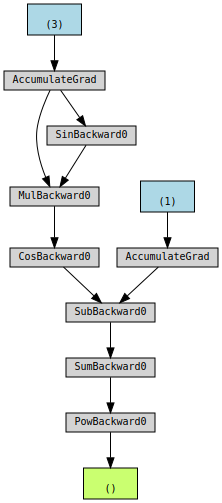

In [26]:
x = torch.rand(3,requires_grad=True)
p = torch.rand(1,requires_grad=True)

f = torch.sum(torch.cos(torch.sin(x)*x)-p)**2

from torchviz import make_dot
make_dot(f)

Les deux boites bleues correspondent aux variables d'entrée x et p ; si on veut que ces noms apparaissent sur le graphe il faut le spécifier ainsi :

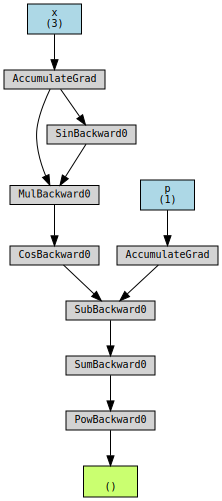

In [27]:
make_dot(f, {'x':x, 'p':p})

On peut remarquer que les noms des fonctions correspondent en fait aux fonctions de calcul du gradient et pas de la fonction elle-même. Du coup le graphe affiché est un peu trompeur, car les flèches indiquent le sens du calcul forward, alors que les fonctions sont les fonctions utilisées pour la rétro-propagation. Ceci vient du fait que PyTorch ne crée véritablement un graphe de calcul que pour le gradient ; il n'a pas besoin de le faire pour la fonction elle-même.

D'ailleurs si on cherche à afficher le graphe de calcul de la fonction gradient, ça ne fonctionnera que si on a spécifié `create_graph=True` :

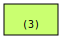

In [28]:
# essai d'affichage du graphe de calcul du gradient sans l'option create_graph=True
gfx, gfp = torch.autograd.grad(f,[x,p])
make_dot(gfx, {'x':x, 'p':p})

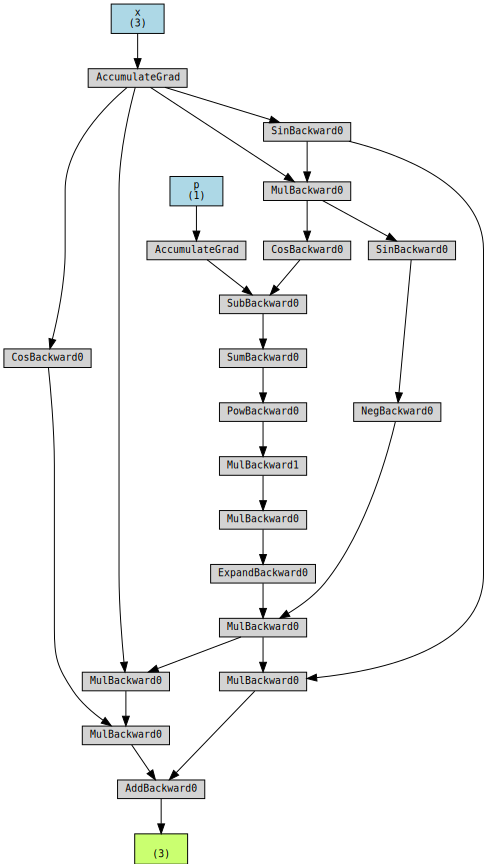

In [29]:
# affichage du graphe de calcul du gradient

# N.B. Ici on doit recalculer f car on vient déjà de faire le calcul des gradients
f = torch.sum(torch.cos(torch.sin(x)*x)-p)**2

gfx, gfp = torch.autograd.grad(f,[x,p],create_graph=True)
make_dot(gfx, {'x':x, 'p':p})

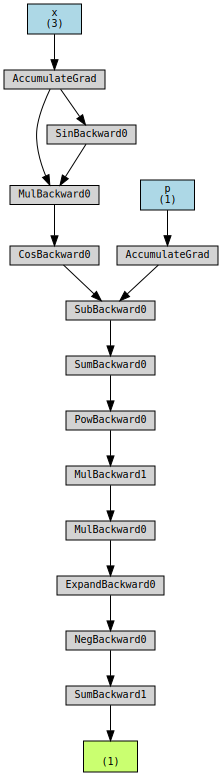

In [30]:
make_dot(gfp, {'x':x, 'p':p})

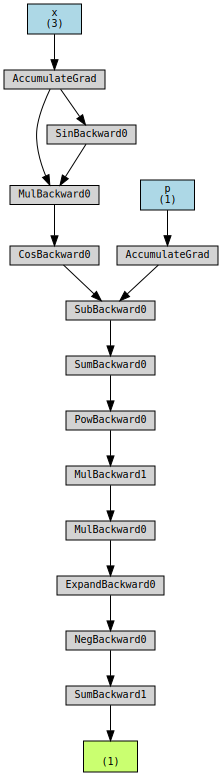

In [31]:
gfpp, = torch.autograd.grad(gfp,[p],create_graph=True)
make_dot(gfpp, {'x':x, 'p':p})

Remarquons que ce dernier graphe de calcul est loin d'être optimal : dans ce cas précis on peut voir facilement en calculant à la main que la dérivée seconde de f par rapport à p est constante est vaut 18. 
C'est bien la valeur obtenue :

In [32]:
gfpp

tensor([18.], grad_fn=<SumBackward1>)

mais elle est obtenue en faisant toute une série de calculs... PyTorch applique à l'aveugle la règle de dérivation des fonctions composées mais n'a aucun mécanisme de simplification des expressions algébriques.